# Please use google colab... this is made using google colab with some function only exist in google colab...

Raymond Rafael Chen - 2301856485

# Download Dataset from kaggle

using my own Kaggle API to connect to Google Colab.
then unzip the picture

In [4]:
def dataset_init():
  !pip install -q kaggle
  from google.colab import files
  #Upload Kaggle API Key...
  files.upload()
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle competitions download -c dogs-vs-cats
  !unzip test1.zip
  !unzip train.zip

# Import + Stuff


Using  GPU to accelerate training, which was taking more than 6 hours per epoch when using CPU...

In [1]:
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip -q install --upgrade tensorflow

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Model Creation



Dropping output layer from VGG16 and made our own output layer with 128 node as the connection to the output layer and using relu as the activation function for the hidden 128 node and using sigmoid as the activation function for the output

In [2]:
def define_model():
    # VGC16 use 224x224
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    flat = Flatten()(model.layers[-1].output)
    clas = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(clas)
    model = Model(inputs=model.inputs, outputs=output)
    sgd = SGD(learning_rate=0.001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Just arranging the photo to their own class folder

Cat.####.jpg goes to cat and same as for the dog

The important thing to note from this function, it will be splitted 25% randomly for training and cross validation...

Training with 0.75 (75%)
Testing with 0.25 (25%)

In [3]:
def prepare_dataset():	
	# organize dataset into a useful structure
	from os import makedirs, listdir
	from shutil import move
	from random import seed, random
	# create directories
	dataset_home = 'Training_Dataset/'
	subdirs = ['train/', 'test/']
	for subdir in subdirs:
		# create label subdirectories
		labeldirs = ['dogs/', 'cats/']
		for labeldir in labeldirs:
			newdir = dataset_home + subdir + labeldir
			makedirs(newdir, exist_ok=True)
	# seed random number generator
	seed(1)
	# define ratio of pictures to use for validation ( 25% for testing)
	ratio = 0.25
	# copy training dataset images into subdirectories
	src_dir = 'train/'
	for file in listdir(src_dir):
		src = src_dir + '/' + file
		dst_dir = 'train/'
		if random() < ratio:
			dst_dir = 'test/'
		if file.startswith('cat'):
			dst = dataset_home + dst_dir + 'cats/'  + file
			move(src, dst)
		elif file.startswith('dog'):
			dst = dataset_home + dst_dir + 'dogs/'  + file
			move(src, dst)

# Just need to be run once per runtime

In [ ]:
dataset_init()
prepare_dataset()

# Model Creation + Training

6 hours+++ on cpu...

Just found out that my tensorflow in my laptop doesn't use gpu at all and i'm waiting for the training for hours... really hoping to knew it from the start..

GPU banzai, mostly 6-7 mins per epoch is so good

Becasuse we need to get the center of the image... ImageDataGenerator will get the center feauture then we provide the mean of the dataset.

which then will be used to train and validate the model...

epoch = 5, with binary mode because only cats and dogs in binary is 0 and 1, with 224 x 224 size and 64 batch

18697 photos / 64 batch = 293 photos per batch

In [5]:
model = define_model()
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]
train = datagen.flow_from_directory('../content/Training_Dataset/train/', class_mode='binary', batch_size=64, target_size=(224, 224))
test = datagen.flow_from_directory('../content/Training_Dataset/test/', class_mode='binary', batch_size=64, target_size=(224, 224))
history = model.fit_generator(train, steps_per_epoch=len(train), epochs=5, validation_data=test, validation_steps=len(test), verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
293/293 [==============================] - 325s 1s/step - loss: 0.3042 - accuracy: 0.8959 - val_loss: 0.0909 - val_accuracy: 0.9667
Epoch 2/5
293/293 [==============================] - 290s 988ms/step - loss: 0.0470 - accuracy: 0.9836 - val_loss: 0.0767 - val_accuracy: 0.9718
Epoch 3/5
293/293 [==============================] - 289s 985ms/step - loss: 0.0196 - accuracy: 0.9932 - val_loss: 0.0787 - val_accuracy: 0.9743
Epoch 4/5
293/293 [==============================] - 288s 982ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.0783 - val_accuracy: 0.9752
Epoch 5/5
293/293 [==============================] - 287s 980ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.0836 - val_accuracy: 0.9776


AttributeError: ignored

In [7]:
_, acc = model.evaluate_generator(test, steps=len(test), verbose=0)
print(f"Acc: {acc*100}%")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Acc: 97.76297211647034%


# Plotting

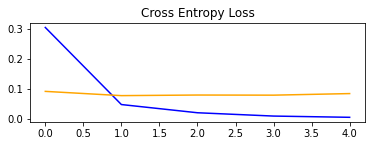

In [8]:
# Cross Entropy
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')

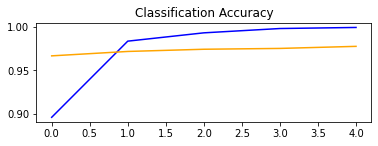

In [9]:
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

In [14]:
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history2 = model.fit(train, steps_per_epoch=len(train), epochs=5, validation_data=test, validation_steps=len(test), verbose=1)
_, acc2 = model.evaluate_generator(test, steps=len(test), verbose=0)
print(f"Acc: {acc2*100}%")

Epoch 1/5
293/293 [==============================] - 290s 987ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0881 - val_accuracy: 0.9779
Epoch 2/5
293/293 [==============================] - 287s 981ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.1307 - val_accuracy: 0.9692
Epoch 3/5
293/293 [==============================] - 287s 978ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.0843 - val_accuracy: 0.9806
Epoch 4/5
293/293 [==============================] - 286s 976ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0748 - val_accuracy: 0.9803
Epoch 5/5
293/293 [==============================] - 286s 976ms/step - loss: 9.5805e-04 - accuracy: 0.9998 - val_loss: 0.0812 - val_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Acc: 98.42932224273682%
